In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

# Load the CSV file
df = pd.read_csv('performance_snapshot.csv', delimiter='|')

# Map sequential programs to their names
sequential_mapping = {
    'parallel_simple_loop_openmp': 'sequential_simple_loop',
    'parallel_loop_unrolling_openmp': 'sequential_loop_unrolling',
    'parallel_loop_fusion_openmp': 'sequential_loop_fusion',
    'parallel_combined_optimizations_openmp': 'sequential_combined_optimizations'
}

# Initialize lists to store computed metrics
speedup = []
efficiency = []
work = []
thread_times = []
overhead = []

# Iterate over the DataFrame to calculate speedup, efficiency, work, and thread times
for index, row in df.iterrows():
    program_name = row['program_name']
    threads_count = row['threads_count']
    
    if program_name in sequential_mapping:
        seq_program = sequential_mapping[program_name]
        seq_time = df[(df['program_name'] == seq_program) & (df['threads_count'] == 1)]['execution_time'].values[0]
        
        # Speedup 
        speed = round(seq_time / row['execution_time'], 2)
        speedup.append(speed)
        
        # Work 
        work_done = round(row['execution_time'] * threads_count, 2)
        work.append(work_done)

        # Expected Ideal Time
        expected_ideal_time = round(seq_time / threads_count, 2)
        
        # Overhead
        current_overhead = round(row['execution_time'] - expected_ideal_time, 2)
        overhead.append(current_overhead)

        # Efficiency 
        eff = round(speed / threads_count, 2)
        efficiency.append(eff)
        
        # Parse thread times from JSON
        if 'thread_times' in row and isinstance(row['thread_times'], str):
            thread_time = json.loads(row['thread_times'])
            thread_times.append(thread_time)
        else:
            thread_times.append({})

    else:
        # NaN for sequential programs
        speedup.append(None)
        efficiency.append(None)
        work.append(None)
        overhead.append(None)
        thread_times.append({})

# Add the calculated values to the DataFrame
df['speedup'] = speedup
df['efficiency'] = efficiency
df['work'] = work
df['overhead'] = overhead
df['thread_times'] = thread_times

# Save the report to CSV
df.to_csv('performance_report.csv', index=False)

# Print the updated DataFrame
print(df)

                              program_name           start_date  \
0                   sequential_simple_loop  2024-09-28 19:19:28   
1                sequential_loop_unrolling  2024-09-28 19:19:57   
2                   sequential_loop_fusion  2024-09-28 19:20:26   
3        sequential_combined_optimizations  2024-09-28 19:21:03   
4              parallel_simple_loop_openmp  2024-09-28 19:21:28   
5              parallel_simple_loop_openmp  2024-09-28 19:21:52   
6              parallel_simple_loop_openmp  2024-09-28 19:22:05   
7              parallel_simple_loop_openmp  2024-09-28 19:22:17   
8           parallel_loop_unrolling_openmp  2024-09-28 19:23:11   
9           parallel_loop_unrolling_openmp  2024-09-28 19:23:23   
10          parallel_loop_unrolling_openmp  2024-09-28 19:23:30   
11          parallel_loop_unrolling_openmp  2024-09-28 19:23:35   
12             parallel_loop_fusion_openmp  2024-09-28 19:23:55   
13             parallel_loop_fusion_openmp  2024-09-28 19:24:1

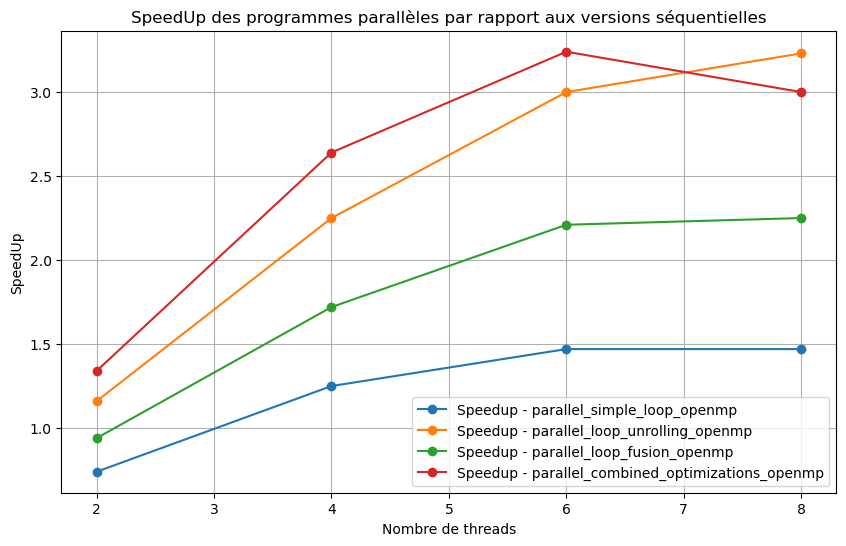

In [5]:
# Plot Speedup
plt.figure(figsize=(10, 6))
for program in df['program_name'].unique():
    if 'parallel' in program:
        subset = df[df['program_name'] == program]
        plt.plot(subset['threads_count'], subset['speedup'], marker='o', label=f"Speedup - {program}")

plt.title("SpeedUp des programmes parallèles par rapport aux versions séquentielles")
plt.xlabel("Nombre de threads")
plt.ylabel("SpeedUp")
plt.legend()
plt.grid(True)
plt.show()

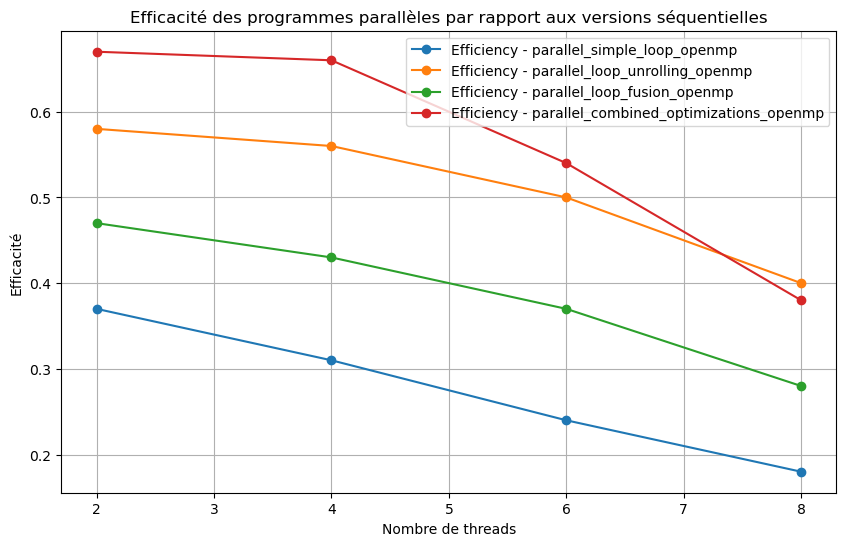

In [4]:
# Plot Efficiency
plt.figure(figsize=(10, 6))
for program in df['program_name'].unique():
    if 'parallel' in program:
        subset = df[df['program_name'] == program]
        plt.plot(subset['threads_count'], subset['efficiency'], marker='o', label=f"Efficiency - {program}")

plt.title("Efficacité des programmes parallèles par rapport aux versions séquentielles")
plt.xlabel("Nombre de threads")
plt.ylabel("Efficacité")
plt.legend()
plt.grid(True)
plt.show()

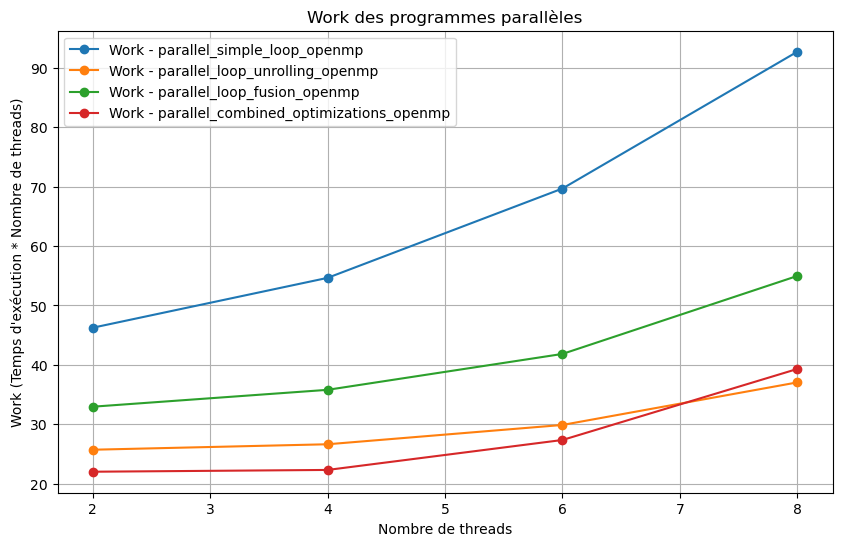

In [6]:
# Plot Work
plt.figure(figsize=(10, 6))
for program in df['program_name'].unique():
    if 'parallel' in program:
        subset = df[df['program_name'] == program]
        plt.plot(subset['threads_count'], subset['work'], marker='o', label=f"Work - {program}")

plt.title("Work des programmes parallèles")
plt.xlabel("Nombre de threads")
plt.ylabel("Work (Temps d'exécution * Nombre de threads)")
plt.legend()
plt.grid(True)
plt.show()

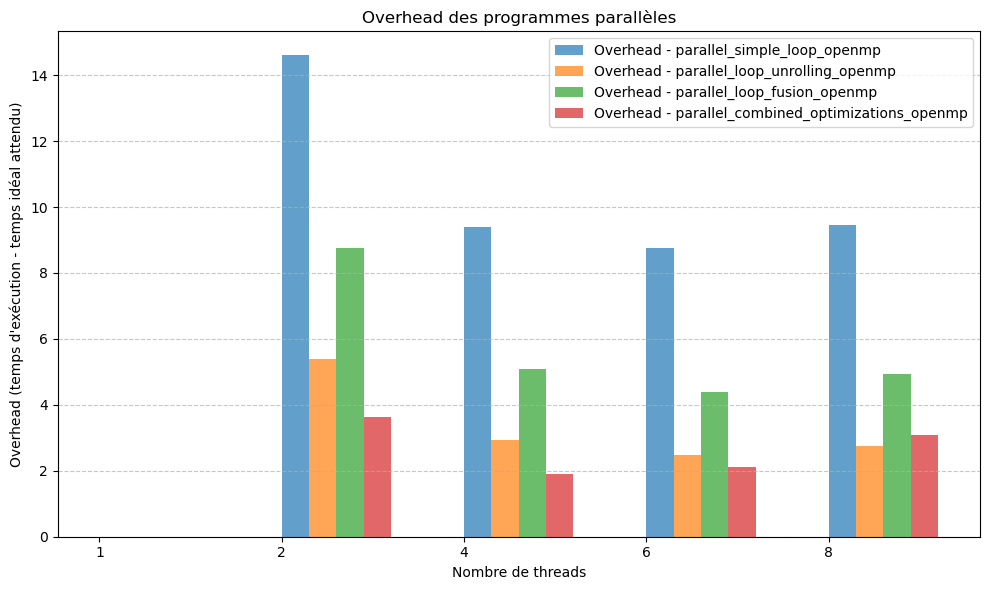

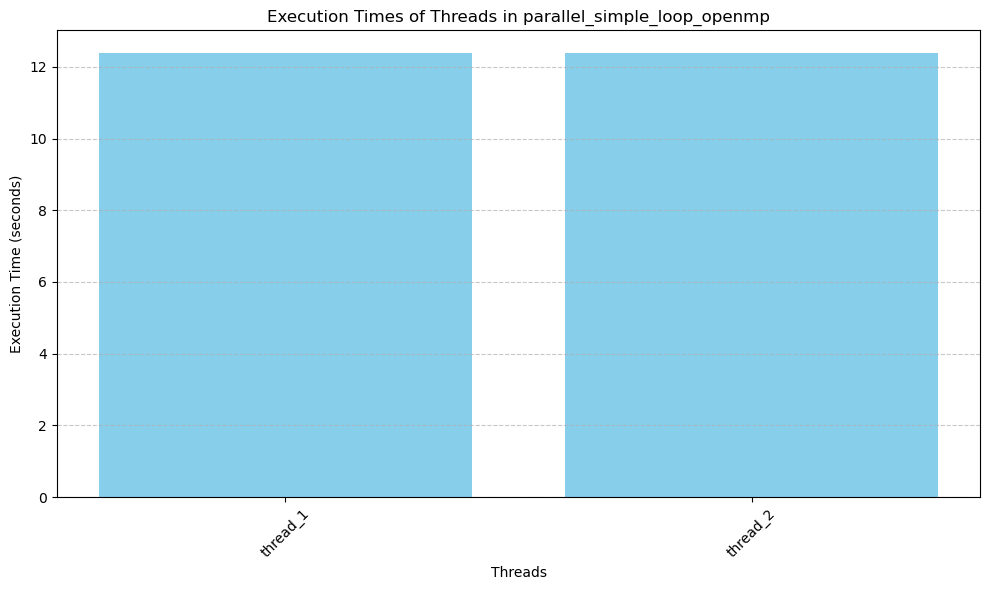

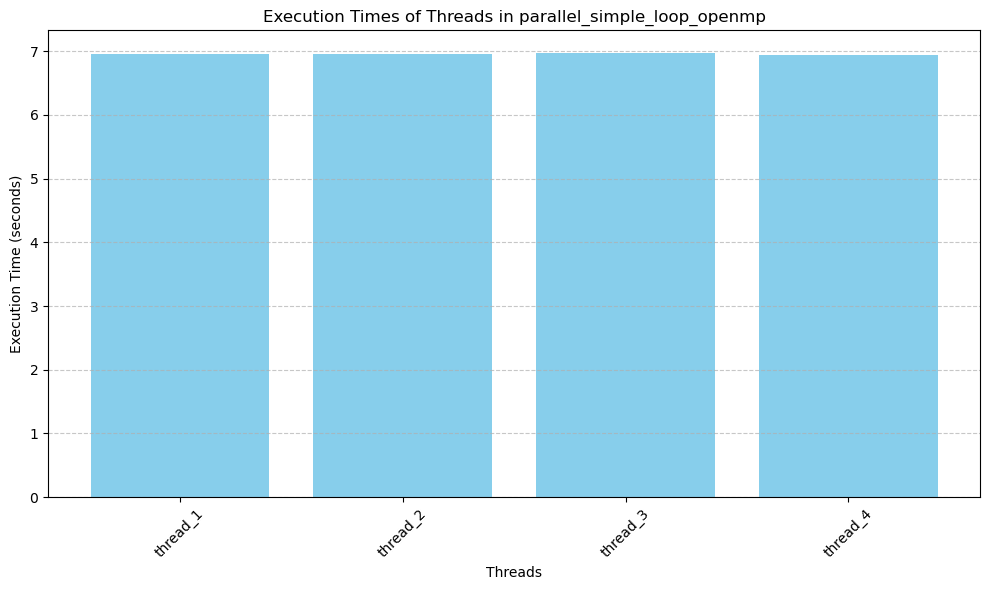

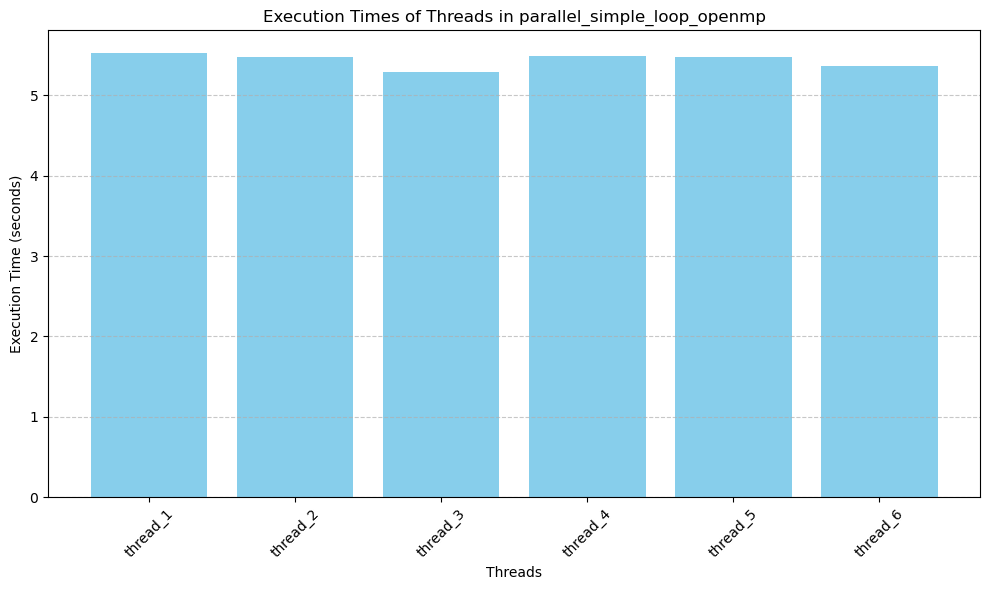

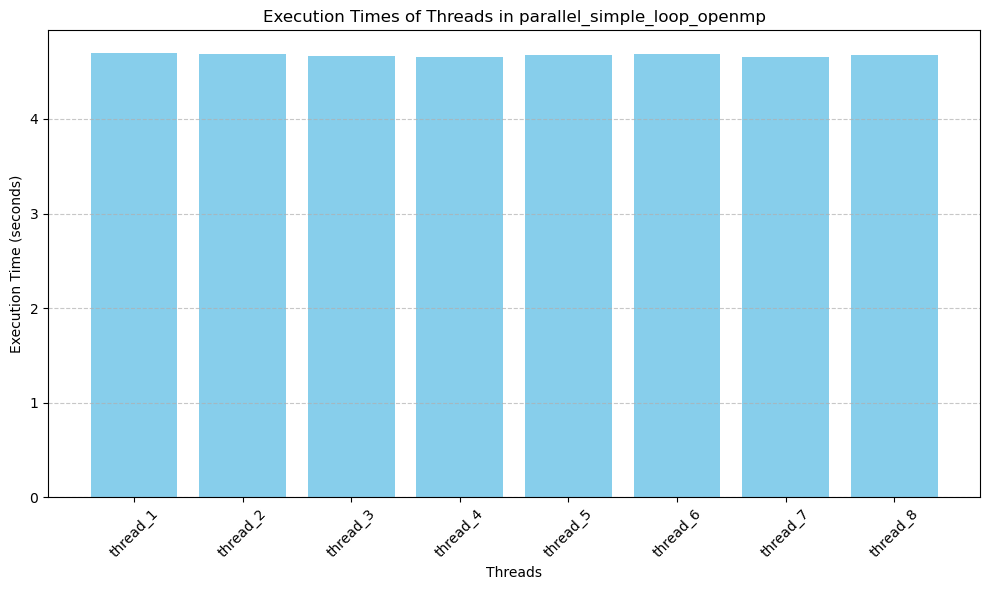

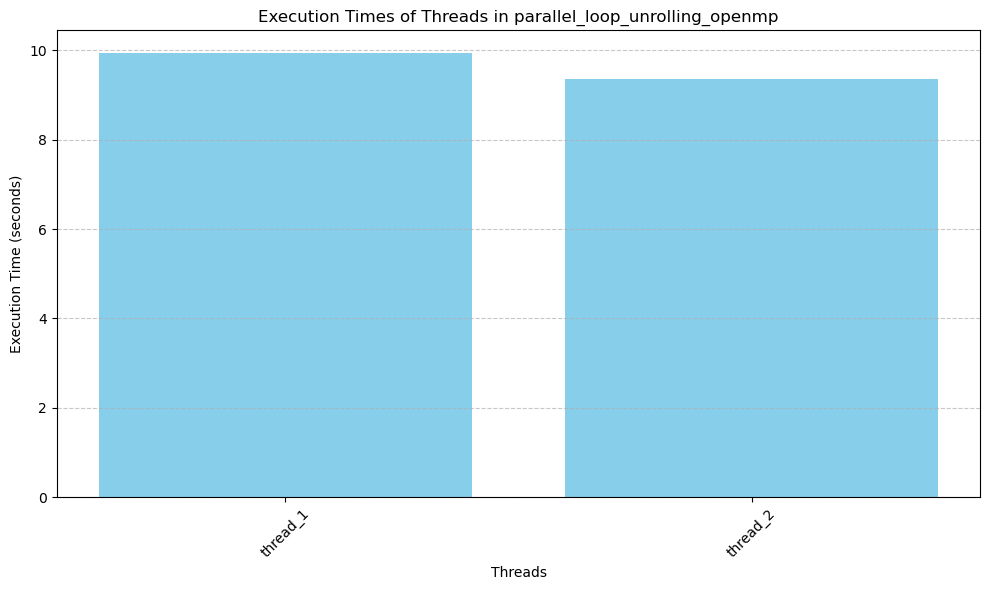

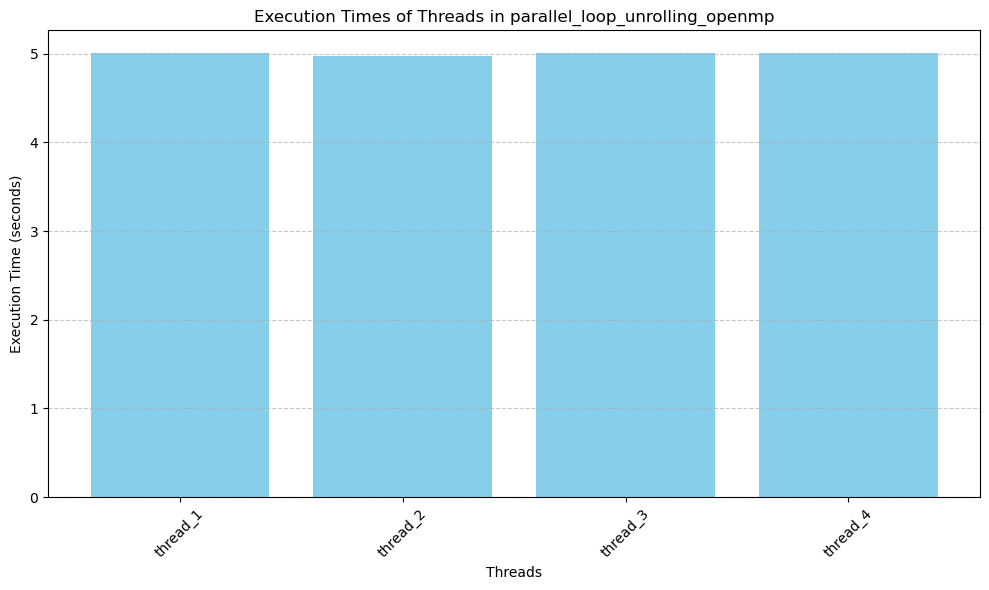

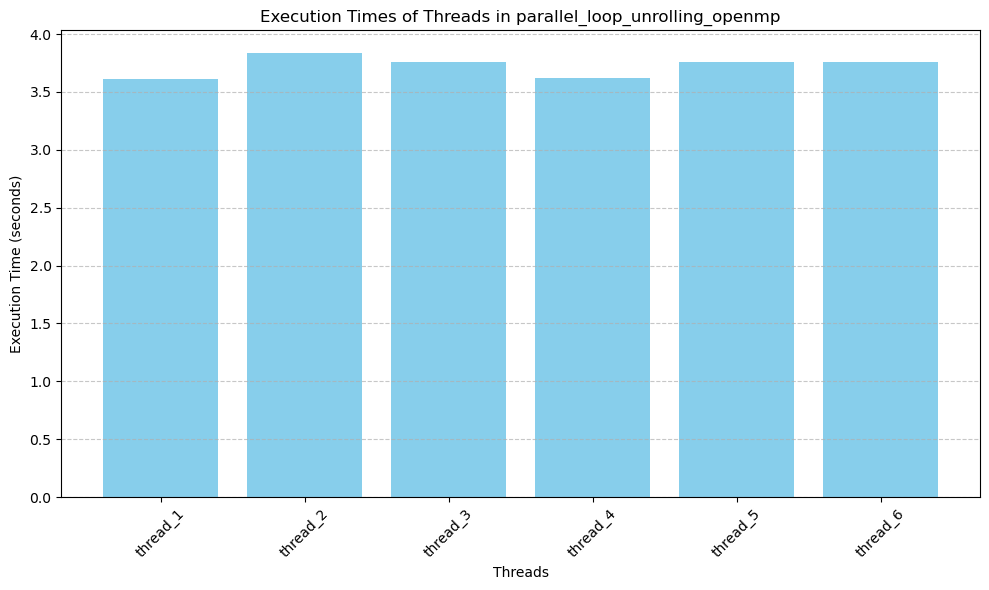

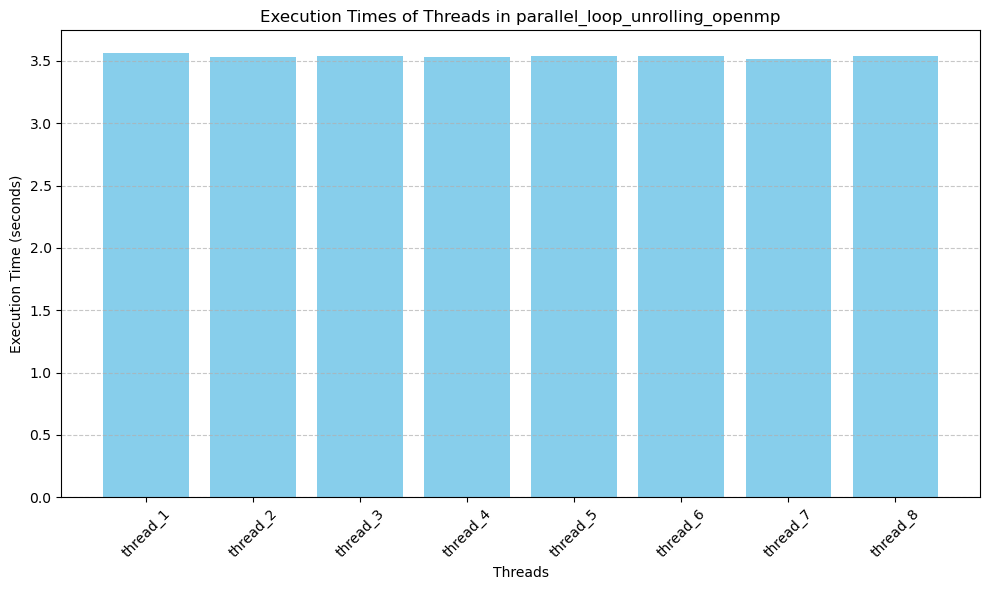

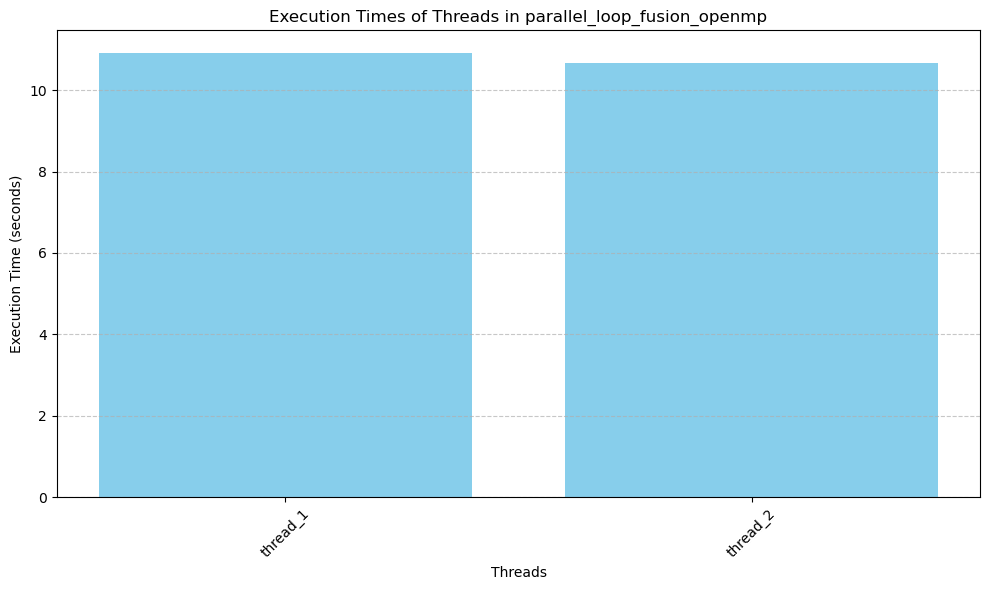

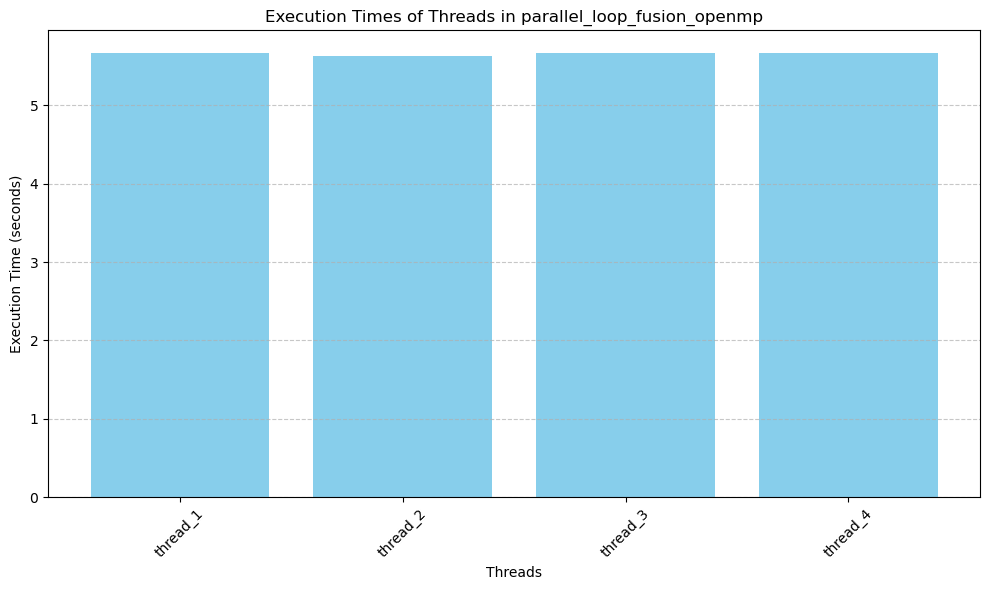

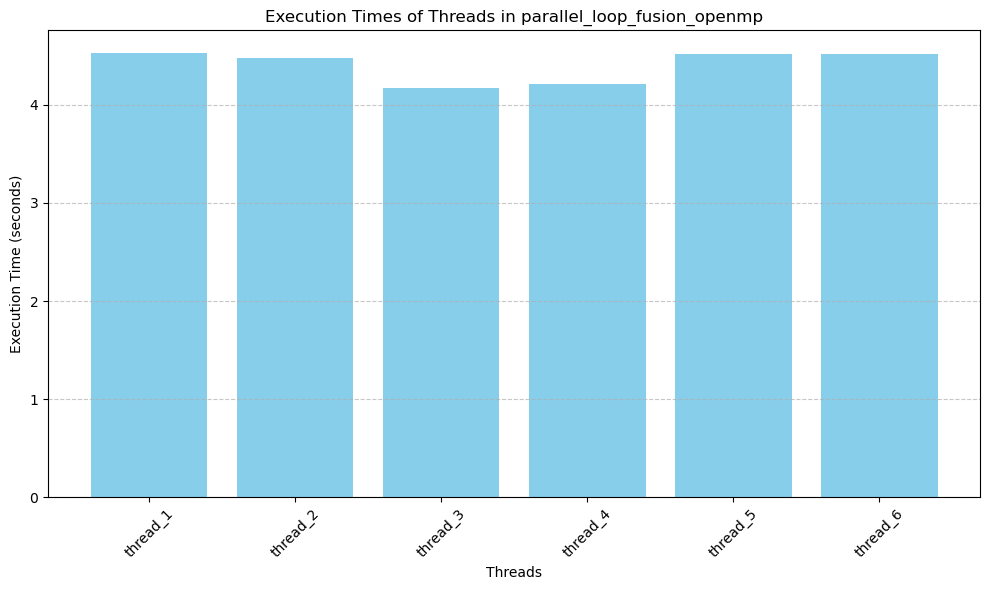

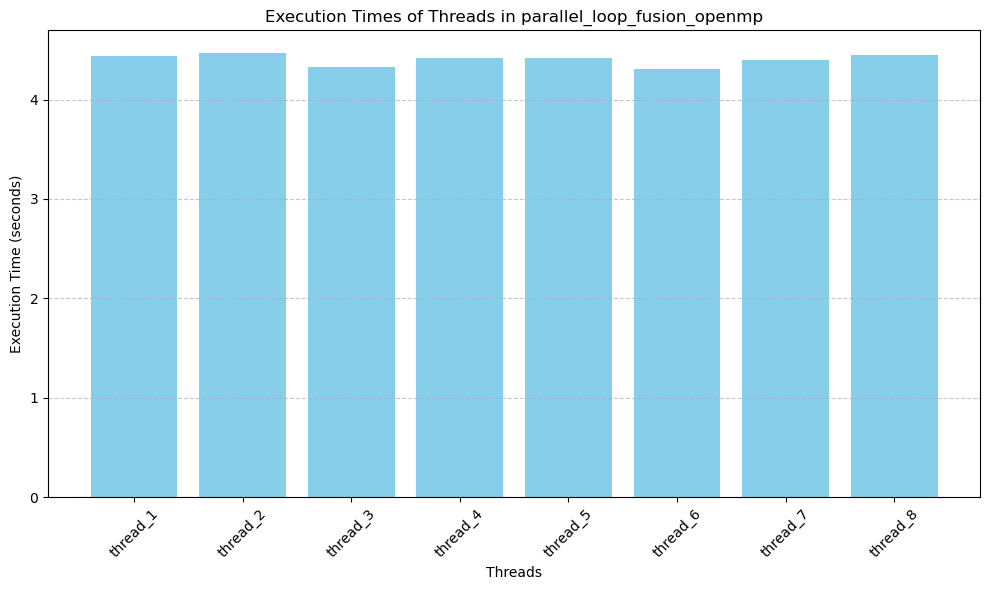

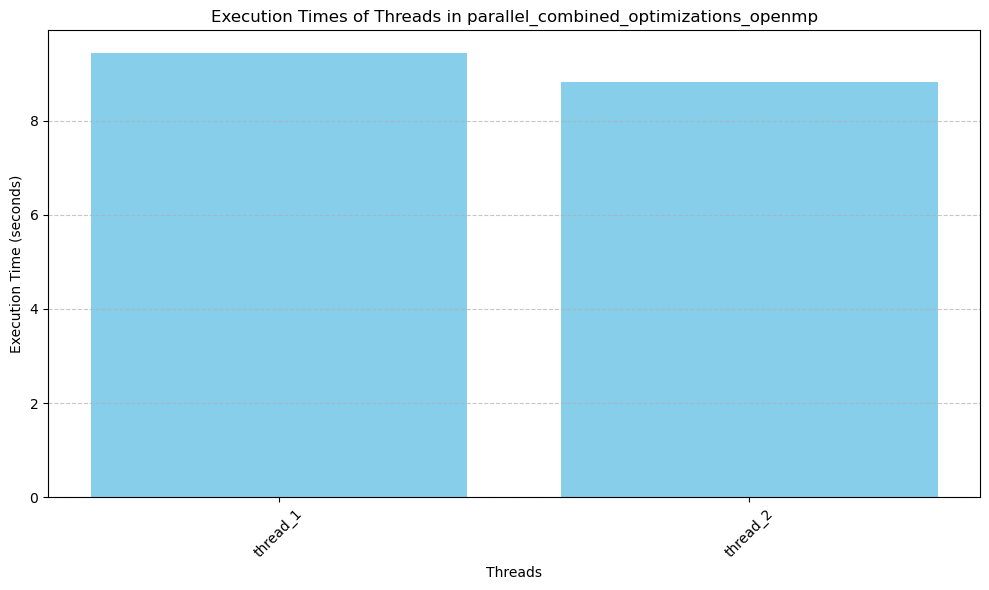

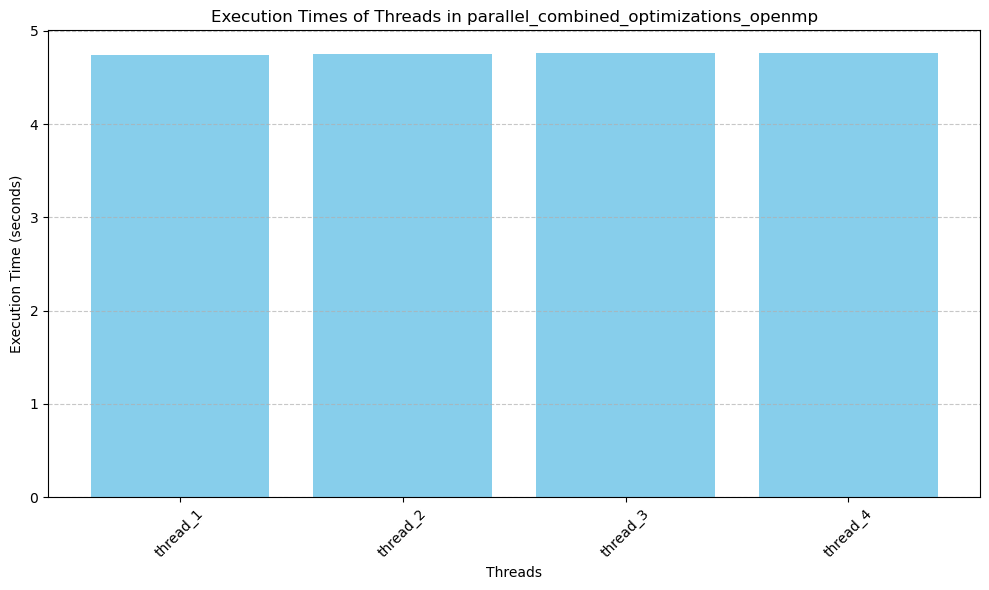

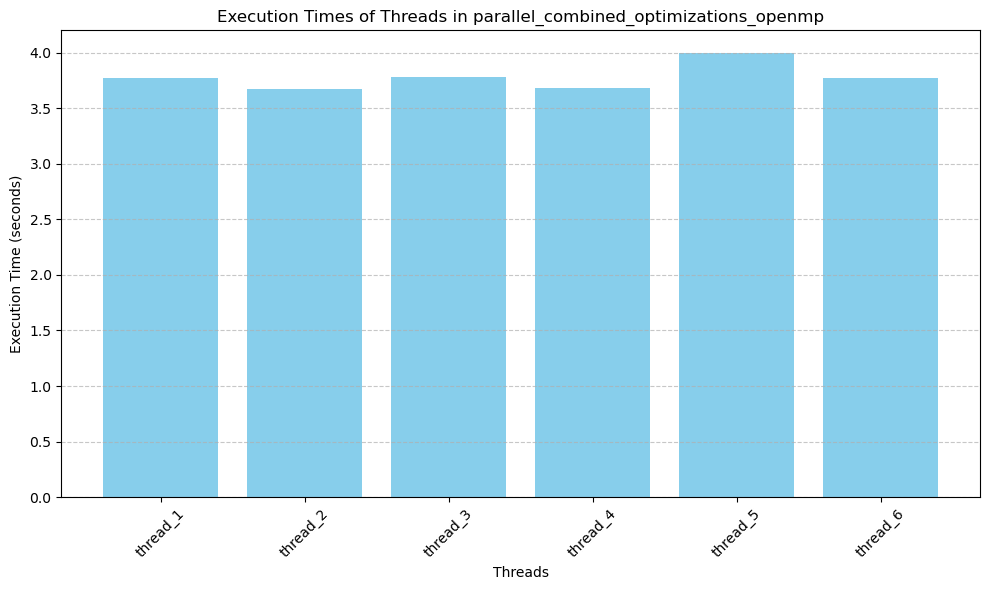

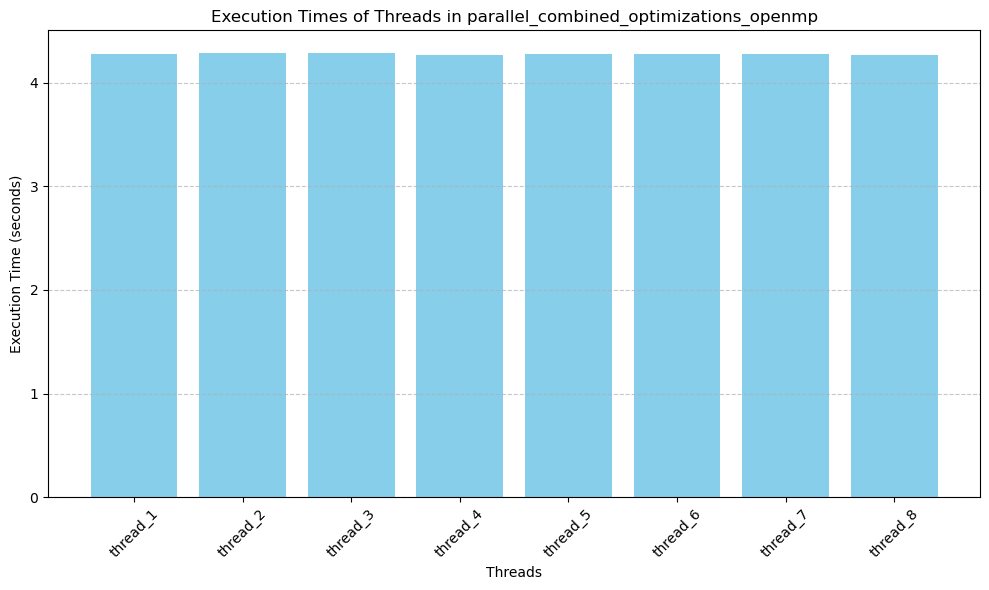

In [7]:
# Plot Overhead
plt.figure(figsize=(10, 6))

bar_width = 0.15  # Width of each bar
unique_threads = df['threads_count'].unique()  # Get unique thread counts
x_indices = np.arange(len(unique_threads))  # X indices for threads count

# Initialize a list to keep track of bar heights
bar_positions = []

for i, program in enumerate(df['program_name'].unique()):
    if 'parallel' in program:
        subset = df[df['program_name'] == program]

        # Filter valid overhead and thread counts
        valid_subset = subset[subset['overhead'].notna() & subset['threads_count'].notna()]

        # Get the overhead values for the current program based on unique threads
        heights = [valid_subset[valid_subset['threads_count'] == thread]['overhead'].values[0] 
                   if not valid_subset[valid_subset['threads_count'] == thread]['overhead'].empty 
                   else 0 for thread in unique_threads]

        center_x = x_indices + (i - (len(df['program_name'].unique()) - 1) / 2) * (bar_width)

        # Plot the bars at the centered position
        plt.bar(center_x, heights, 
                width=bar_width, label=f"Overhead - {program}", alpha=0.7)

# Adjust x-axis ticks and labels
plt.title("Overhead des programmes parallèles")
plt.xlabel("Nombre de threads")
plt.ylabel("Overhead (temps d'exécution - temps idéal attendu)")
plt.xticks(x_indices, unique_threads)  # Set ticks to match unique thread counts
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Plot Thread Execution Times as Bar Charts
for index, row in df.iterrows():
    program_name = row['program_name']
    if 'parallel' in program_name:
        thread_time = row['thread_times']
        if thread_time:
            # Extract thread names and their respective times
            thread_names = list(thread_time.keys())
            times = list(thread_time.values())

            # Create a bar plot for each program
            plt.figure(figsize=(10, 6))
            plt.bar(thread_names, times, color='skyblue')
            plt.title(f"Execution Times of Threads in {program_name}")
            plt.xlabel("Threads")
            plt.ylabel("Execution Time (seconds)")
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()  # Adjust layout to prevent clipping
            plt.show()